In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

import config
config.config(channel='shap',lemo='lo',n_steps=8,cfg_bits=[0,1,0,1,0,1,1],cfg_inst=True)

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')
Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


    Low terminal: FLO
    Auto output off: 1
    Protection: 1
    Resistance mode: FIX
    Shunt resistance : +2.00000000E+009
    Output current mode: FIX
    Output current level: -1.00000000E-006
    Output voltage range: +2.00000000E+000
    Output status: 1
        
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


    Number of pattern positions: +1000
    Source of the trigger: IMM
    Period of the pulse: +1.5000E-08
    Duty cycle of the pulse: +5.0000E+01
    Rise time of the pulse: +3.0000E-09
    Type of pulse: PATTERN
    CH1 data: 20 1's, 980 0's
    CH2 data: as the clock
    STRB data: 20 1's, 980 0's
    Type of the pulse: NRZ
    Internal impedance (source): +5.0000E+01
    External impedance (termination): +1.0000E+02
    High level: +1.2000E+00
    Low level: +0.0000E+00
    Output 1 status: 1
    Output 2 status: 1
        
LECROY,

In [2]:
channel_name = config.channel_name
lemo_name = config.lemo_name
gain = config.lemo_gain
gain_shap = config.gain_shap
N_samples = 500

# set proper time division for this analysis
#config.lecroy.write('TDIV 200NS')
# suppress channel for noise stuff
config.lecroy.write('F3:TRA OFF')
# set cursor positions
# in future one must set vdiv, hdiv, ... TODO
# current: tdiv = 200 ns/div,, delay = -908 ns
ndiv = 10 # positive and negative around delay
tdelay = -908 # ns
tdiv = 200 # ns/div
osc_ts = 329 # ns
osc_te = osc_ts + config.peaking_time # TODO not ideal
osc_offset = - ndiv/2*tdiv - tdelay
div_s = (osc_ts - osc_offset)/tdiv
if config.channel_name == 'shap':
    div_e = (osc_te - osc_offset)/tdiv
else:
    div_e = (432 - osc_offset)/tdiv

# no injection for noise (check withouth injection circuit TODO)
# Set zero output
config.pg.write(':OUTP1 ON')
config.pg.write(':OUTP2 OFF')
config.ps.write(':SOUR:CURR:LEV 0')
#config.ps.write(':SOUR:CURR:LEV 0')
#config.ps.write(':OUTP:STAT OFF')

N_repetitions = 16
background = False
absolute = False
if absolute:
    config.lecroy.write(f'C2:CRS HABS')
    config.lecroy.write(f'C2:CRST HABS,{div_e}')
else:
    config.lecroy.write(f'C2:CRS HREL')
    config.lecroy.write(f'C2:CRST HDIF,{div_s},HREF,{div_e}')

data = np.empty((N_samples, N_repetitions))
for i in range(N_repetitions):
    # N sample to average and extract std from
    for j in range(N_samples):
        if absolute:
            data[j,i] = float(config.lecroy.query(f'C{config.channel_num}:CRVA? HABS').split(',')[2])
        else:
            data[j,i] = float(config.lecroy.query(f'C{config.channel_num}:CRVA? HREL').split(',')[2])

data = data*10**3
noise_std      = np.mean(np.std(data,axis=0))
noise_std_std  = np.std(np.std(data,axis=0))
noise_rms      = np.mean(np.sqrt(np.mean(np.square(data),axis=0)))
noise_rms_std  = np.std(np.sqrt(np.mean(np.square(data),axis=0)))
enc_std        = np.sqrt(noise_std**2)/gain/gain_shap*9000/3.65
enc_std_std    = noise_std_std/gain/gain_shap*9000/3.65
enc_rms        = np.sqrt(noise_rms**2)/gain/gain_shap*9000/3.65
enc_rms_std    = noise_rms_std/gain/gain_shap*9000/3.65

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
df = pd.DataFrame([[
    noise_std    ,
    noise_std_std,
    noise_rms    ,
    noise_rms_std,
    enc_std      ,
    enc_std_std  ,
    enc_rms      ,
    enc_rms_std  ,
]], columns=[
    'noise std (mV)',
    'noise std std (mV)',
    'noise rms (mV)',
    'noise rms std (mV)',
    'ENC std (e-)',
    'ENC std std (e-)',
    'ENC rms (e-)',
    'ENC std std (e-)',
])

df.to_csv(f'G:/My Drive/PHD/FALCON/measures/enc/enc_{config.config_bits_str}_{datetime_str}_{lemo_name}_{'background_' if background else ''}{'absolute' if absolute else ''}.tsv', sep='\t')
df 

KeyboardInterrupt: 

In [32]:
np.std(data,axis=0)

array([3.4705247 , 3.98447385, 3.62911398, 3.95393046, 3.58639892,
       3.94354927, 3.85240423, 3.84338841, 3.63914678, 3.88528249,
       4.04109228, 3.9162583 , 3.9833629 , 3.65863765, 4.00588239,
       3.9094448 ])

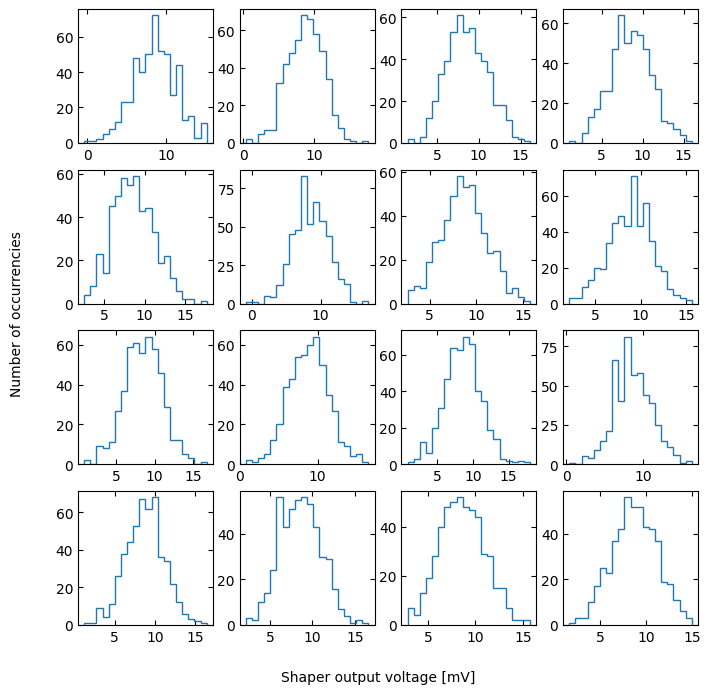

In [11]:
colours = list(mcolors.TABLEAU_COLORS.keys())
fig, ax = plt.subplots(4,4)
fig.set_figheight(8)
fig.set_figwidth(8)
for i in range(16):
	if (i < N_repetitions):
		ax[i//4,i%4].hist(
			data[:,i],
			histtype='step', fill=False, bins=20)
	ax[i//4,i%4].tick_params(right=True, top=True, direction='in')
fig.text(0.5, 0.04, 'Shaper output voltage [mV]', ha='center')
fig.text(0.04, 0.5, 'Number of occurrencies', va='center', rotation='vertical')

fig.savefig(f'G:/My Drive/PHD/FALCON/measures/enc/distributions_{config.config_bits_str}_{datetime_str}_{lemo_name}{'_background' if background else ''}{'_absolute' if absolute else ''}.pdf',dpi=300)


In [17]:
# old method setting long window
channel_name = config.channel_name
gain = config.lemo_gain
gain_shap = config.gain_shap
N_samples = 100

current_level_step = 4
current_lev = config.current_lev[current_level_step]
photon_span = np.linspace(0,256,8)

# set proper time division for this analysis
config.lecroy.write('TDIV 1MS')
time.sleep(5) # long time division needs time
# enable channel for noise stuff
config.lecroy.write('F3:TRA ON')
# Set zero output
config.pg.write(':OUTP1 OFF')
config.pg.write(':OUTP2 OFF')
config.ps.write(':SOUR:CURR:LEV 0')

data_std = []
data_rms = []
data_std_csa = []
data_rms_csa = []
for _ in range(N_samples):
    data_std.append(float(config.lecroy.query('PAST? CUST,P9').split(',')[9]))
    data_rms.append(float(config.lecroy.query('PAST? CUST,P10').split(',')[9]))
    data_std_csa.append(float(config.lecroy.query('PAST? CUST,P11').split(',')[9]))
    data_rms_csa.append(float(config.lecroy.query('PAST? CUST,P12').split(',')[9]))
    time.sleep(0.03)

noise_std      = np.average(data_std)*10**3
noise_std_std  = np.std(data_std)*10**3
noise_rms      = np.average(data_rms)*10**3
noise_rms_std  = np.std(data_rms)*10**3
noise_std_csa      = np.average(data_std_csa)*10**3
noise_std_std_csa  = np.std(data_std_csa)*10**3
noise_rms_csa      = np.average(data_rms_csa)*10**3
noise_rms_std_csa  = np.std(data_rms_csa)*10**3
enc_std        = np.sqrt(noise_std**2 - 3.7**2)/gain/gain_shap*9000/3.65
enc_std_std    = noise_std_std/gain/gain_shap*9000/3.65
enc_rms        = np.sqrt(noise_rms**2 - 3.8**2)/gain/gain_shap*9000/3.65
enc_rms_std    = noise_rms_std/gain/gain_shap*9000/3.65
enc_std_csa        = np.sqrt(noise_std_csa**2 - 3**2)/gain/gain_shap*9000/3.65
enc_std_std_csa    = noise_std_std_csa/gain/gain_shap*9000/2.07
enc_rms_csa        = np.sqrt(noise_rms_csa**2 - 5**2)/gain/gain_shap*9000/3.65
enc_rms_std_csa    = noise_rms_std_csa/gain/gain_shap*9000/2.07

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
df = pd.DataFrame([[
    noise_std    ,
    noise_std_std,
    noise_rms    ,
    noise_rms_std,
    enc_std      ,
    enc_std_std  ,
    enc_rms      ,
    enc_rms_std  ,
]], columns=[
    'noise std (mV)',
    'noise std std (mV)',
    'noise rms (mV)',
    'noise rms std (mV)',
    'ENC std (e-)',
    'ENC std std (e-)',
    'ENC rms (e-)',
    'ENC std std (e-)',
])

df2 = pd.DataFrame([[
    noise_std_csa    ,
    noise_std_std_csa,
    noise_rms_csa    ,
    noise_rms_std_csa,
    enc_std_csa      ,
    enc_std_std_csa  ,
    enc_rms_csa      ,
    enc_rms_std_csa  
]], columns=[
    'noise std CSA (mV)',
    'noise std std CSA (mV)',
    'noise rms CSA (mV)',
    'noise rms std CSA (mV)',
    'ENC std CSA (e-)',
    'ENC std std CSA (e-)',
    'ENC rms CSA (e-)',
    'ENC std std CSA (e-)'
])

df.to_csv(f'G:/My Drive/PHD/FALCON/measures/enc/enc_{config.config_bits_str}_{datetime_str}.tsv', sep='\t')

from IPython.display import display
display(df)
display(df2)

,noise std (mV),noise std std (mV),noise rms (mV),noise rms std (mV),ENC std (e-),ENC std std (e-),ENC rms (e-),ENC std std (e-)
0,4.401,0.00995,4.404,0.019596,752.792185,3.143145,703.198721,6.19031


,noise std CSA (mV),noise std std CSA (mV),noise rms CSA (mV),noise rms std CSA (mV),ENC std CSA (e-),ENC std std CSA (e-),ENC rms CSA (e-),ENC std std CSA (e-)
0,3.099,0.00995,5.772,0.182253,245.467326,5.54226,910.969002,101.517979


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors
import config

path = 'G:/My Drive/PHD/FALCON/measures/enc/enc_0101011_160424_181440.tsv'
df = pd.read_csv(path,sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
arr_split = path.split('/')
channel_name = arr_split[6]
config_bits_str = arr_split[-1].split('_')[1]
config_bits = [int(x) for x in config_bits_str]
config.config(channel='shap',n_steps=20,cfg_bits=config_bits,cfg_inst=False)

channel_name = config.channel_name
gain = config.lemo_gain
gain_shap = config.gain_shap

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
df['ENC std (e-)'] = np.sqrt(df['noise std (mV)']**2 - 3.7**2)/gain/gain_shap*9000/3.65
df['ENC rms (e-)'] = np.sqrt(df['noise rms (mV)']**2 - 4.5**2)/gain/gain_shap*9000/3.65
df.to_csv(f'G:/My Drive/PHD/FALCON/measures/enc/enc_{config.config_bits_str}_{datetime_str}.tsv', sep='\t')
df

current range: -7e-08, -1.500815660685155e-06
Injection integral (min and max): 1.0000000000000084e-16, -1.7159787928221857e-13
photon energy @ 9 keV: -0.2531557775003489, 434.40994547100695
Peaking time: 405 ns
Config bits: 0101011
Channel to be tested: shap


,Unnamed: 0,noise std (mV),noise std std (mV),noise rms (mV),noise rms std (mV),ENC std (e-),ENC std std (e-),ENC rms (e-),ENC std std (e-).1
0,0,4.372,0.201534,4.638,0.315525,735.735972,63.66421,354.741417,99.673681


In [7]:
# VARIANZA E NON STD
# letture da lemo shaper
# ci sono 3.7 mV senza chip su scheda (std, mentre rms è circa 4.1)
# arrivano a 4.7 mV, 5 mV con chip su scheda (rms circa 4.9 mV, 5.1 mV) tp = 405 ns.
# arrivano a 4.2 mV, 4.8 mV con chip su scheda (rms circa 4.9 mV, 5.1 mV) tp = 495 ns.
# il rumore si considera sottratto di rumore scheda
# calcolo per ENC = (std rumore/(gainscheda*gain_csa/shap)*energia_photon/silicio
# se considero il rumore della scheda lo devo togliere alla lettura della std
print(f'ENC (std, @ tp=405 ns) = {(((4.7 + 5)/2 - 3.7)/(2.1/.65))/2.416*9000/3.65} e-') # tp = 405 ns
print(f'ENC (rms, @ tp=405 ns) = {(((4.9 + 5.1)/2 - 4.1)/(2.1/.65))/2.416*9000/3.65} e-') # tp = 405 ns
print(f'ENC (std, @ tp=495 ns) = {(((4.2 + 4.8)/2 - 3.7)/(2.1/.65))/2.31*9000/3.65} e-') # tp = 495 ns
print(f'ENC (rms, @ tp=495 ns) = {(((4.8 + 5.1)/2 - 3.7)/(2.1/.65))/2.31*9000/3.65} e-') # tp = 495 ns

ENC (std, @ tp=405 ns) = 363.2826168660332 e-
ENC (rms, @ tp=405 ns) = 284.3081349386349 e-
ENC (std, @ tp=495 ns) = 264.31494141865954 e-
ENC (rms, @ tp=495 ns) = 412.99209596665537 e-


In [104]:
print(config.lecroy.query('PAST? CUST,P9'))
print(config.lecroy.query('PAST? CUST,P10'))

CUST,P9,SDEV,C2,AVG,5.38E-3,HIGH,461.6E-3,LAST,4.4E-3,LOW,3.7E-3,SIGMA,21.02E-3,SWEEPS,116.368E+3
CUST,P10,RMS,C2,AVG,5.68E-3,HIGH,463.1E-3,LAST,4.5E-3,LOW,3.7E-3,SIGMA,21.06E-3,SWEEPS,116.374E+3


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

import config
config.config(channel='shap',lemo='lo',n_steps=8,cfg_bits=[0,1,0,1,0,1,1],cfg_inst=True)
#print(config.lecroy.query('C1:CRVA? HREL').split(',')[2])

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')
Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


    Low terminal: FLO
    Auto output off: 1
    Protection: 1
    Resistance mode: FIX
    Shunt resistance : +2.00000000E+009
    Output current mode: FIX
    Output current level: -1.00000000E-006
    Output voltage range: +2.00000000E+000
    Output status: 1
        
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


    Number of pattern positions: +1000
    Source of the trigger: IMM
    Period of the pulse: +1.5000E-08
    Duty cycle of the pulse: +5.0000E+01
    Rise time of the pulse: +3.0000E-09
    Type of pulse: PATTERN
    CH1 data: 20 1's, 980 0's
    CH2 data: as the clock
    STRB data: 20 1's, 980 0's
    Type of the pulse: NRZ
    Internal impedance (source): +5.0000E+01
    External impedance (termination): +1.0000E+02
    High level: +1.2000E+00
    Low level: +0.0000E+00
    Output 1 status: 1
    Output 2 status: 1
        
LECROY,

12

In [29]:
config.ps.write(':SOUR:CURR:LEV 1E-7')
# Set zero output
config.pg.write(':OUTP1 ON')
config.pg.write(':OUTP2 OFF')
#config.ps.write(':SOUR:CURR:LEV 0')

12